# Challenge: When Will the Sakura Bloom?


# Problem definition: Basics of the Sakura Bloom-cycle

In a year, sakura trees basically go through 4 phases: energy production, hibernation, growth, and of course flowering. These phases
roughly follow the seasons, but not exactly. <br>

   Production phase： Initial development of the buds（Summer-Fall） <br>
   Hibernation phase： Bud growth stops while the tree goes into hibernation（Late Fall-Winter） <br>
   Growth phase： Buds once again continue to grow when the tree comes out of its winter hibernation（Late Winter-Spring） <br>
   Flowering phase： The buds finally bloom in spring (as climate conditions allow), once they have been able to fully develop.（Spring） <br>
    
Each year, near the end of winter but before the trees finally bloom, the hibernation period ends. The sakura that rested through the winter once gain become metabolically active, and the buds continue to grow (though we may not immediately notice when this happens.) However, the cycle is not simply clockwork- for example, in places where the temperature is above 20℃ year-round, the trees are unable to hibernate sufficiently, and thus cannot blossom.
    
In this challenge, we have outlined the basic mechanism by which the sakura reach their eventual bloom-date. We consider building a bloom-date prediction model for the case of sakura in Tokyo, with the data split as follows: <br>
    
Test years： 1966, 1971, 1985, 1994, and 2008 <br>
Training years: 1961 to 2017 (Excluding the test years) <br>
    
You should fit the model to the data from the training years, then use the model to predict the bloom-date for each of the test years.
    


# Abstract:
Based on different features of weather data of Tokyo, the blooming date of Sakura flower(cherry blossom) is to be predicted by diffrent models and accuracies are to be compared based on r2 score. Along with two given models, an ANN model has been proposed here. Required processing and feature engineering has been done and explained with proper tuning of hyper parameters.


### Problem 0-1: (5pts)
Acquire data of sakura blooming date (桜の開花日) for Tokyo from 1961 to 2018 using the Japanese Meteorological Agency website (気象庁).

# Data collection:
 Weather data(Tokyo) of everyday from January,1961 to March,2017 has been collected from  Japanese Meteorological Agency website(https://www.jma.go.jp/jma/en/menu.html) . The collected features in the dataset are-<br>
 1. Local pressure<br>
 2. Sea pressure<br>
 3. Precipitation data<br>
 4. Maximum,minimum and average temperature data<br>
 5. Sun hours<br>
 6. Average and minimum humidity<br>
 7. Blooming date of Sakura in Tokyo for each year

# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import tensorflow as tf

# Functions

In [2]:
def UpdateDayCount(dframe,y):
    #Takes dataframe and list of years
    #Returns updated dataframe with numbered days for each year 
    grouped_df = dframe.groupby('year')
    last =0
    for i in range(len(y)):
        sub_df = grouped_df.get_group(y[i])
        for j in range(sub_df.shape[0]):
            k = j+last
            dframe.loc[k,'day_count'] = j+1
        last = k+1
    return dframe

In [3]:
def ActualBD(dframe,y):
    actual_days=[]
    grouped = dframe.groupby('year')
    for i in range(len(y)):
        actual_day = 0
        tempo = grouped.get_group(y[i])
        total_days = tempo.shape[0]
        tempo = tempo.reset_index(drop=True)
        for p in range(total_days):
            if tempo.loc[p,'bloom']==0:
                actual_day = 0
            else:
                actual_day = tempo.loc[p,'day_count']
                break
        actual_days.append(actual_day)    

    bd_df = pd.DataFrame({'years':y,'day:actual':actual_days})
    return bd_df

In [4]:
def SplitDataSet(dframe,t_years): 
    #Takes total dataframe and values of 'test' years
    #Returns separate train and test dataframes
    train_dframe = dframe[~dframe['year'].isin(t_years)]
    train_dframe = train_dframe.reset_index(drop=True)
    test_dframe = dframe[dframe['year'].isin(t_years)]
    test_dframe = test_dframe.reset_index(drop=True)
    return train_dframe,test_dframe

In [5]:
def ThresholdDegreeRule(dframe,degree,y):
    #Takes a dataframe,Threshold temperature value for blooming and a list of years
    #Returns prediction of blooming date for each year
    b_count =[]
    b_month =[]
    b_day = []
    sum_values = []
    actual_days=[]
    grouped = dframe.groupby('year')
    for i in range(len(y)):
        actual_day = 0
        tempo = grouped.get_group(y[i])
        total_days = tempo.shape[0] #Needs to be counted before dropping January
        tempo =tempo[tempo.month != 1] #Excluding January to start from February 1st
        tempo = tempo.reset_index(drop=True)
        sum_deg = 0
        for j in range(total_days):
            day_no = tempo.loc[j,'day_count']
            sum_deg= sum_deg+ tempo.loc[j,'max temp']
            if sum_deg>degree:
               break
        b_count.append(day_no)
        for p in range(total_days):
            if tempo.loc[p,'bloom']==0:
                actual_day = 0
            else:
                actual_day = tempo.loc[p,'day_count']
                break
        actual_days.append(actual_day)    
        sum_values.append(sum_deg)
    pred = pd.DataFrame({'years':y,'day:actual':actual_days,'day:predicted':b_count,'sum':sum_values})
    
    return pred

In [6]:
def AccMaxTempCounter(dframe,y):
    #Takes dataframe and list of years
    #Returns dataframe of accumulated maximum temperature for each year
    acc_temp_list = []
    grouped = dframe.groupby('year')
    for i in range(len(y)):
        tempo = grouped.get_group(y[i])
        total_days = tempo.shape[0]
        tempo = tempo[tempo.month != 1] #Excluding January because calculation starts from February 1st
        tempo = tempo.reset_index(drop=True)
        acc_temp = 0
        for j in range(total_days):
            if tempo.loc[j,'bloom'] == 0:
                acc_temp = acc_temp + tempo.loc[j,'max temp']
            else:
                acc_temp = acc_temp + tempo.loc[j,'max temp']
                break
        acc_temp_list.append(acc_temp)    
    df = pd.DataFrame({'years':y,'AccMaxTempLimit':acc_temp_list})
    return df

In [7]:
def CalcTmean(acc_df,y):
    T = acc_df.loc[:,'AccMaxTempLimit'].sum(axis=0)
    Tmean = T/len(train_years)
    return Tmean

In [8]:
def CalcR2Score(actual,pred):
    R2= r2_score(actual,pred)
    return R2

In [9]:
def CalcMSE(actual,pred):
    mse = mean_squared_error(actual,pred)
    return mse

In [10]:
def CalcTf(dframe,y):
    avg_temp_list = []
    grouped = df.groupby('year')
    for i in range(len(y)):
        tempo = grouped.get_group(y[i])
        tempo = tempo.reset_index(drop = True)
        sum_temp =0
        for j in range(tempo.shape[0]):
            if tempo.loc[j,'month']<4:
                sum_temp = sum_temp + tempo.loc[j,'avg temp']
            else:
                break
        avg_temp_list.append(sum_temp/j) #Will be divided by j because j starts from 0
    avg_temp_df = pd.DataFrame({'YEARS':y,'AVG_TEMP3m': avg_temp_list})
    return avg_temp_df

In [11]:
def CalcDj(fi,L,Tf_dframe,y):
    #Takes values to calculate Dj for each year and year list
    #Returns Dj value of each year in a dataframe
    dj_list = []
    x1 = 136.75 -(7.689*fi)+(0.133*fi*fi)-(1.307*(np.log(L)))
    for i in range(Tf_dframe.shape[0]):
        q =Tf_dframe.loc[i,'AVG_TEMP3m']
        x2 = 0.144*q + 0.285*q*q
        dj = x1+x2
        dj = int(dj)
        #dj = round(dj)
        #dj = int(dj)
        dj_list.append(dj)
    Dj_df= pd.DataFrame({'Dj':dj_list,'YEARS':y})
    return Dj_df

In [12]:
def CalcDTSj(Ea,dj_df,act_bd_df,dframe,y):
    R = 8.314
    Ts = 290 #in Kelvin
    Ea = Ea*4184 #in joule
    dj_list = np.array(dj_df['Dj'])
    ABD_list = np.array(act_bd_df['day:actual'])
    DTSj_list = []

    grouped = dframe.groupby('year')
    for i in range(len(y)):
        DTSj = 0
        tempo = grouped.get_group(y[i])
        tempo = tempo.reset_index(drop=True)
        Dji = dj_list[i]
        BD = ABD_list[i]
        for j in range(Dji,BD+1):
            Tij=tempo.loc[j-1,'avg temp']
            Tij = Tij+273
            ts=Calc_ts(Ea,Tij,Ts,R)
            DTSj = DTSj +ts
            #DTSj = round(DTSj)
            #DTSj = int(DTSj)
        DTSj_list.append(DTSj)
    return DTSj_list

In [13]:
def Calc_ts(Ea,Tij,Ts,R):
    A = Tij-Ts
    B = Ea*A
    C= R*Tij*Ts
    D = B/C
    ts = np.exp(D)
    return ts

In [14]:
def FindingMSE(dframe,dj_df,actBD_df,DTSmean_df,y):
    #Calculated mean square error between actual and predicted values
    R = 8.314 
    Ts = 290 
    
    MSE_perEa = []
    Dj_list = np.array(dj_df['Dj'])  #This is per year
    ABD_list = np.array(actBD_df['day:actual']) #This is per year
    DTSi = DTSmean_df['DTSmean'].values.tolist()
    
    grouped = dframe.groupby('year')
    for i in range(len(Ea_list)):
        DTSmean_ = DTSi[i]
        Ea = Ea_list[i]*4184
        pred_BD =[]
        for i in range(len(y)):
            DTSj = 0
            tempo = grouped.get_group(y[i])
            tempo = tempo.reset_index(drop=True)
            Dji = Dj_list[i]
            for j in range(Dji,tempo.shape[0]):
                Tij=tempo.loc[j-1,'avg temp']
                Tij = Tij+273
                ts=Calc_ts(Ea,Tij,Ts,R)
                if DTSj<DTSmean_:
                    DTSj = DTSj+ts
                else:
                    BD_pred = j
                    break
            pred_BD.append(BD_pred)
        PRED_BD=np.array(pred_BD)
        #print('ABD_list:',ABD_list)
        #print('PRED_BD:',PRED_BD)
        #print(len(ABD_list),len(PRED_BD))
        #MSE = CalcMSE(ABD_list,PRED_BD)
        MSE = mean_squared_error(ABD_list,PRED_BD)
        #print(MSE)
        MSE_perEa.append(MSE)
    MSE_Ea_df = pd.DataFrame({'Ea value(Kcal)':Ea_list,'MSE Score':MSE_perEa})
    return MSE_Ea_df      


In [15]:
def FindingEabyR2(dframe,dj_df,actBD_df,DTSmean_df,y):
    R = 8.314 
    Ts = 290 
    
    r2_perEa = []
    Dj_list = np.array(dj_df['Dj'])  #This is per year
    ABD_list = np.array(actBD_df['day:actual']) #This is per year
    DTSi = DTSmean_df['DTSmean'].values.tolist()
    
    grouped = dframe.groupby('year')
    for i in range(len(Ea_list)):
        DTSmean = DTSi[i]
        Ea = Ea_list[i]*4184
        pred_BD =[]
        for i in range(len(y)):
            DTSj = 0
            tempo = grouped.get_group(y[i])
            tempo = tempo.reset_index(drop=True)
            Dji = Dj_list[i]
            for j in range(Dji,tempo.shape[0]):
                Tij=tempo.loc[j-1,'avg temp']
                Tij = Tij+273
                ts=Calc_ts(Ea,Tij,Ts,R)
                if DTSj<DTSmean:
                    DTSj = DTSj+ts
                else:
                    BD_pred = j
                    break
            pred_BD.append(BD_pred)
        PRED_BD=np.array(pred_BD)
        #print('ABD_list:',ABD_list)
        #print('PRED_BD:',PRED_BD)
        #print(len(ABD_list),len(PRED_BD))
        r2 = CalcR2Score(ABD_list,PRED_BD)
        #print(MSE)
        r2_perEa.append(r2)
    r2_Ea_df = pd.DataFrame({'Ea value(Kcal)':Ea_list,'r2 Score':r2_perEa})
    return r2_Ea_df 

In [59]:
def PREDByBestEaDTSmeas(dframe,dj_df,actBD_df,Ea,DTSmean,y):
    R = 8.314 
    Ts = 290 
    
    Dj_list = np.array(dj_df['Dj'])  #This is per year
    ABD_list = actBD_df['day:actual'].values.tolist() #This is per year
    
    
    grouped = dframe.groupby('year') 
    Ea = Ea*4184
    pred_BD =[]
    for i in range(len(y)):
        DTSj = 0
        tempo = grouped.get_group(y[i])
        tempo = tempo.reset_index(drop=True)
        Dji = Dj_list[i]
        for j in range(Dji,tempo.shape[0]):
            Tij=tempo.loc[j-1,'avg temp']
            Tij = Tij+273
            ts=Calc_ts(Ea,Tij,Ts,R)
            if DTSj<DTSmean:
                DTSj = DTSj+ts
            else:
                BD_pred = j-1
                break
        pred_BD.append(BD_pred)
    pred_df = pd.DataFrame({'day:predicted':pred_BD,'day:actual':ABD_list,'years':y})
    
    return pred_df

In [17]:
def CreateFeat(dframe,y,S_M,E_M,feat_name):
    c_dframe=dframe.copy()
    grouped = c_dframe.groupby('year')
    year_values = []
    for i in range(len(y)):
        tempo = grouped.get_group(y[i])
        value_list = []
        for m in range(S_M,E_M+1):
            feat_sum = 0
            value =0
            sub_df =tempo[tempo.month == m]
            sub_df = sub_df.reset_index(drop=True)
            feat_sum = sub_df[feat_name].sum()
            value = feat_sum/sub_df.shape[0]
            value_list.append(value)
        year_values.append(value_list)
    new_feat = E_M-S_M+1
    col = list(range(S_M,E_M+1))
    new_df = pd.DataFrame(year_values,columns=col)
    new_df['year']=y
    return new_df

# Preprocessing steps

In [18]:
#READING DATA
df = pd.read_csv('sakura.csv')

In [19]:
#DELETING UNNECESSARY COLUMNS
del df['serial']
#Adding columns
df['day_count']=0
df['actual BD']=0
#NECCESSARY INPUT VARIABLES
test_years = [1966,1971,1985,1994,2008]

In [20]:
all_years = df.year.unique().tolist()

In [21]:
df = UpdateDayCount(df,all_years)

In [22]:
ActualBD_df = ActualBD(df,all_years) 
print(ActualBD_df)

    day:actual  years
0           91   1961
1           91   1962
2           91   1963
3           93   1964
4           92   1965
5           79   1966
6           89   1967
7           89   1968
8           96   1969
9           97   1970
10          89   1971
11          88   1972
12          90   1973
13          92   1974
14          88   1975
15          82   1976
16          81   1977
17          90   1978
18          82   1979
19          91   1980
20          85   1981
21          82   1982
22          90   1983
23         102   1984
24          93   1985
25          93   1986
26          82   1987
27          93   1988
28          79   1989
29          79   1990
30          89   1991
31          84   1992
32          83   1993
33          90   1994
34          90   1995
35          91   1996
36          80   1997
37          86   1998
38          83   1999
39          90   2000
40          82   2001
41          75   2002
42          86   2003
43          78   2004
44        

In [23]:
train_df,test_df=SplitDataSet(df,test_years)

In [24]:
train_years=train_df.year.unique().tolist()

In [25]:
ActualBD_tr = ActualBD(train_df,train_years)
ActualBD_test = ActualBD(test_df,test_years)
print(ActualBD_test)

   day:actual  years
0          79   1966
1          89   1971
2          93   1985
3          90   1994
4          82   2008


# Missing value checking

In [26]:
#Checking if any of the year has any missing values
grouped = df.groupby('year')
for i in range(len(all_years)):
        tempo = grouped.get_group(all_years[i])
        if tempo.shape[0]!= 365:
            print(all_years[i],tempo.shape[0])

1964 366
1968 366
1972 366
1976 366
1980 366
1984 366
1988 366
1992 366
1996 366
2000 366
2004 366
2008 366
2012 366
2016 366
2017 90


***
## 1. Prediction using the "600 Degree Rule" (15pts total)

For a rough approximaton of the bloom-date, we start with a simple "rule-based" prediction model, called the "600 Degree Rule". The rule consists of logging the maximum temperature of each day, starting  on February 1st, and sum these temperatures until the sum surpasses 600$^\circ$C. The day that this happens is the predicted bloom-date. This 600$^\circ$C threshold is used to easily predict bloom-date in various locations varies by location. However, for more precise predictions, it should be set differently for every location. In this challenge, we verify the accuracy of the "600 Degree Rule" in the case of Tokyo.

In [27]:
#PREDICTION ON TRAIN DATA
pred_600_tr=ThresholdDegreeRule(train_df,600,train_years)
print(pred_600_tr)

    day:actual  day:predicted    sum  years
0           91             84  614.6   1961
1           91             78  609.3   1962
2           91             86  609.8   1963
3           93             90  613.9   1964
4           92             90  615.0   1965
5           89             86  612.5   1967
6           89             85  605.3   1968
7           96             88  601.8   1969
8           97             90  600.6   1970
9           88             88  610.4   1972
10          90             84  610.2   1973
11          92             89  603.7   1974
12          88             88  607.9   1975
13          82             83  611.3   1976
14          81             84  602.0   1977
15          90             88  613.4   1978
16          82             80  603.1   1979
17          91             89  601.3   1980
18          85             85  600.1   1981
19          82             84  610.7   1982
20          90             85  602.8   1983
21         102            100  6

In [29]:
actual_tr = np.array(pred_600_tr['day:actual'])
pred_tr_600 = np.array(pred_600_tr['day:predicted'])
R2_600 = CalcR2Score(actual_tr,pred_tr_600)
print('R2 Score for 600 degree rule in TRAIN DATA is:',R2_600)

R2 Score for 600 degree rule in TRAIN DATA is: 0.5841220511371663


In [30]:
#PREDICTION ON TEST DATA
pred_600_test = ThresholdDegreeRule(test_df,600,test_years)
print(pred_600_test)

   day:actual  day:predicted    sum  years
0          79             79  607.6   1966
1          89             86  605.6   1971
2          93             88  604.4   1985
3          90             87  608.9   1994
4          82             83  614.8   2008


In [31]:
actual_test = np.array(pred_600_test['day:actual'])
pred_test_600 = np.array(pred_600_test['day:predicted'])
R2_600 = CalcR2Score(actual_test,pred_test_600)
print('R2 Score for 600 degree rule in TEST DATA is:',R2_600)

R2 Score for 600 degree rule in TEST DATA is: 0.6793002915451896


# Result of 600 Degree Rule:
1. R2 Score on test data is: 0.6793

### Problem 1-1: (5pts)
From here-on, we refer to the bloom-date in a given year $j$ as $BD_{j}$. For each year in the training data, calculate the accumulated daily maximum temperature from February 1st to the actual bloom-date $BD_{j}$, and plot this accumulated value over the training period. Then, average this accumulated value as $T_{mean}$, and verify whether we should use 600$^\circ$C as a rule for Tokyo.

In [32]:
#Accumulated Max Temperature Calculation
acc_t_df_tr = AccMaxTempCounter(train_df,train_years)
print(acc_t_df_tr)

    AccMaxTempLimit  years
0             721.0   1961
1             768.1   1962
2             701.7   1963
3             676.6   1964
4             642.2   1965
5             660.8   1967
6             654.6   1968
7             724.0   1969
8             696.3   1970
9             610.4   1972
10            705.3   1973
11            658.0   1974
12            607.9   1975
13            596.7   1976
14            556.7   1977
15            640.1   1978
16            631.8   1979
17            640.6   1980
18            600.1   1981
19            581.5   1982
20            662.5   1983
21            643.7   1984
22            627.5   1986
23            588.7   1987
24            649.7   1988
25            583.1   1989
26            573.6   1990
27            688.2   1991
28            615.5   1992
29            612.9   1993
30            684.6   1995
31            680.1   1996
32            614.6   1997
33            679.2   1998
34            642.7   1999
35            689.7   2000
3

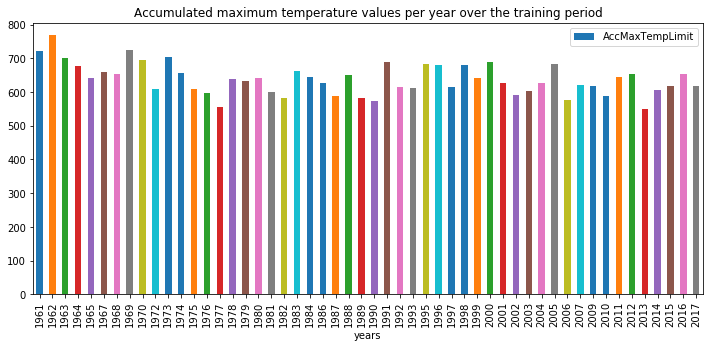

In [33]:
acc_t_df_tr.plot(x='years',y='AccMaxTempLimit',kind = 'bar',figsize=(12,5),title = 'Accumulated maximum temperature values per year over the training period')


In [34]:
Tmean_tr = CalcTmean(acc_t_df_tr,train_years)
print(Tmean_tr)

638.3557692307693


### Verification of 600 degree rule:
The calculated Tmean is 638.35 degree which is higher than 600 degree. So Different result is expected.

### Problem 1-2: (10pts)

Use the average accumulated value $T_{mean}$ calculated in 1-1 to predict $BD_{j}$ for each test year, and show the error from the actual $BD_{j}$. Compare to the prediction results when 600$^\circ$C is used a threshold value, and evaluate both models using the coefficient of determination ($R^2$ score).

In [35]:
pred_Tmean_tr=ThresholdDegreeRule(train_df,Tmean_tr,train_years)
print(pred_Tmean_tr)

    day:actual  day:predicted    sum  years
0           91             87  645.9   1961
1           91             81  641.7   1962
2           91             88  646.3   1963
3           93             92  656.5   1964
4           92             92  642.2   1965
5           89             88  647.0   1967
6           89             88  639.1   1968
7           96             91  644.4   1969
8           97             94  649.7   1970
9           88             90  646.5   1972
10          90             87  656.4   1973
11          92             91  644.5   1974
12          88             90  642.5   1975
13          82             86  645.4   1976
14          81             87  642.7   1977
15          90             90  640.1   1978
16          82             83  648.1   1979
17          91             91  640.6   1980
18          85             88  641.1   1981
19          82             87  646.7   1982
20          90             89  647.6   1983
21         102            102  6

In [36]:
actual_tr = np.array(pred_Tmean_tr['day:actual'])
pred_tr_Tmean = np.array(pred_Tmean_tr['day:predicted'])
R2_600 = CalcR2Score(actual_tr,pred_tr_Tmean)
print('R2 Score for Tmean rule on TRAIN DATA is:',R2_600)

R2 Score for Tmean rule on TRAIN DATA is: 0.7225596835711259


In [37]:
pred_Tmean_test=ThresholdDegreeRule(test_df,Tmean_tr,test_years)
print(pred_Tmean_test)

   day:actual  day:predicted    sum  years
0          79             82  649.7   1966
1          89             88  644.8   1971
2          93             91  644.6   1985
3          90             90  656.6   1994
4          82             85  644.0   2008


In [37]:
actual_test = np.array(pred_Tmean_test['day:actual'])
pred_test_Tmean = np.array(pred_Tmean_test['day:predicted'])
R2_600 = CalcR2Score(actual_test,pred_test_Tmean)
print('R2 Score for Tmean rule on TEST DATA is:',R2_600)

R2 Score for Tmean rule on TEST DATA is: 0.8323615160349854


# Comparison of 600 Degree Rule with Tmean:
R2 scrore on test data using calculated Tmean(638.36 degree) is 0.8323 which is much better than 600 degree rule. So it is wise to calculate Tmean from available dataset instead of using a predefined value.

***
## 2. Linear Regression Model: Transform to Standard Temperature (30pts total)

The year to year fluctuation of the bloom-date depends heavily upon the actual temperature fluctuation (not just the accumulated maximum). In order to get to a more physiologically realistic metric,  Sugihara et al. (1986) considered the actual effect of temperature on biochemical activity. They introduced a method of "standardizing" the temperatures measured, according to the fluctuation relative to a standard temperature.

In order to make such a standardization, we apply two major assumptions, outlined below.

#### 1) The Arrhenius equation: <br>

The first assumption, also known in thermodynamics as the "Arrhenius equation", deals with chemical reaction rates and can be written as follows:

$$
k = A \exp{ \Bigl(- \frac{E_{a}}{RT}} \Bigr)
$$ <br>

Basically, it says that each reaction has an activation energy, $E_{a}$ and a pre-exponential factor $A$. Knowing these values for the particular equation, we can find the rate constant $k$ if we know the temperature, $T$, and applying the universal gas constant, $R = 8.314 \rm [J/K・mol]$.

#### 2) Constant output at constant temperature: <br>

The second assumption, is simply that the output of a reaction is a simple product of the duration and the rate constant $k$, and that product is constant even at different temperatures.
    
$$
tk = t'k' = t''k'' = \cdots = \rm{const}
$$ <br>


Making the assumptions above, we can determine a "standard reaction time", $t_{s}$ required for the bloom-date to occur. We can do so in the following way:

<br>
$$
t_{s} = \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>

We define $T_{i, j}$ as the daily average temperature, and use a standard temperature of $T_{s} = 17^\circ\rm{C}$. For a given year $j$, with the last day of the hibernation phase set as $D_ {j}$, we define the number of "transformed temperature days",  $DTS_{ J}$,  needed to reach from $D_ {j}$ to the bloom-date $BD_{j}$ with the following equation:


<br>
$$
DTS_{j} = \sum_{i=D_{j}}^{BD_{j}} t_{s} = \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>



From that equation, we can find the average $DTS$ for $x$ number of years ($DTS_{ mean}$) as follows: 

<br>
$$
\begin{aligned}
DTS_{\rm{mean}} &= \frac{1}{x} \sum_{j}^{x} DTS_{j} \\
&= \frac{1}{x} \sum_{j}^{x} \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
\end{aligned}
$$ <br> <br>

In this exercise, we assume that $DTS_{ mean}$ and $E_{ a}$ are constant values, and we use the data from the training years to fit these 2 constants. The exercise consists of 4 steps:
1. Calculate the last day of the hibernation phase $D_ {j}$ for every year $j$.
2. For every year $j$, calculate $DTS_{ j}$ as a function of $E_{ a}$, then calculate the average (over training years) $DTS_{ mean}$ also as a function of $E_{ a}$.
3. For every year $j$, and for every value of $E_{ a}$, accumulate $t_{s}$ from $D_ {j}$ and predict the bloom date $BD_{j}^{\rm{pred}}$ as the day the accumulated value surpasses $DTS_{ mean}$. Calculate the bloom date prediction error as a function of $E_{ a}$, and find the optimal $E_{ a}$ value that minimizes that error.
4. Use the previously calculated values of $D_ {j}$, $DTS_{ mean}$, and $E_{ a}$ to predict bloom-day on years from the test set.


In [38]:
#initializing constant values
Fi = 35.67 #Value of latitude [°N] for Tokyo
L = 4 #Distance of Tokyo from the nearest coastline [km]

In [39]:
#Calculating Tf 
Tf_tr = CalcTf(train_df,train_years)
#print(Tf_tr)
#Calculating Dj
Dj_tr = CalcDj(Fi,L,Tf_tr,train_years)
print(Dj_tr)

    Dj  YEARS
0   39   1961
1   41   1962
2   38   1963
3   40   1964
4   38   1965
5   42   1967
6   43   1968
7   42   1969
8   38   1970
9   45   1972
10  44   1973
11  39   1974
12  40   1975
13  45   1976
14  40   1977
15  41   1978
16  50   1979
17  42   1980
18  41   1981
19  45   1982
20  44   1983
21  35   1984
22  39   1986
23  46   1987
24  45   1988
25  51   1989
26  48   1990
27  46   1991
28  48   1992
29  47   1993
30  45   1995
31  45   1996
32  50   1997
33  47   1998
34  48   1999
35  47   2000
36  45   2001
37  55   2002
38  44   2003
39  50   2004
40  45   2005
41  45   2006
42  54   2007
43  50   2009
44  47   2010
45  43   2011
46  42   2012
47  49   2013
48  47   2014
49  46   2015
50  48   2016
51  45   2017


### Problem 2-1: (5pts)
According to Hayashi et al. (2012), the day on which the sakura will awaken from their hibernation phase, $D_{j}$, for a given location, can be approximated by the following equation:
<br> <br>
$$
D_{j} = 136.75 - 7.689 \phi + 0.133 \phi^{2} -1.307\ln L + 0.144T_{F} + 0.285T_{F}^2
$$ <br>

where $\phi$ is the latitude [°N], $L$ is the distance from the nearest coastline [km], and $T_{F}$ is that location's average temperature [°C] over the first 3 months of a given year. In the case of Tokyo, $\phi = 35°40'$ and $L=4\rm{km}$.

Find the $D_{j}$ value for every year $j$ from 1961 to 2017 (including the test years), and plot this value on a graph. 

(In Problem 1, we had assumed a $D_j$ of February 1st.)

In [40]:
Tf_all = CalcTf(df,all_years)
Dj_all = CalcDj(Fi,L,Tf_all,all_years)
print(Dj_all)

    Dj  YEARS
0   39   1961
1   41   1962
2   38   1963
3   40   1964
4   38   1965
5   45   1966
6   42   1967
7   43   1968
8   42   1969
9   38   1970
10  42   1971
11  45   1972
12  44   1973
13  39   1974
14  40   1975
15  45   1976
16  40   1977
17  41   1978
18  50   1979
19  42   1980
20  41   1981
21  45   1982
22  44   1983
23  35   1984
24  41   1985
25  39   1986
26  46   1987
27  45   1988
28  51   1989
29  48   1990
30  46   1991
31  48   1992
32  47   1993
33  43   1994
34  45   1995
35  45   1996
36  50   1997
37  47   1998
38  48   1999
39  47   2000
40  45   2001
41  55   2002
42  44   2003
43  50   2004
44  45   2005
45  45   2006
46  54   2007
47  46   2008
48  50   2009
49  47   2010
50  43   2011
51  42   2012
52  49   2013
53  47   2014
54  46   2015
55  48   2016
56  45   2017


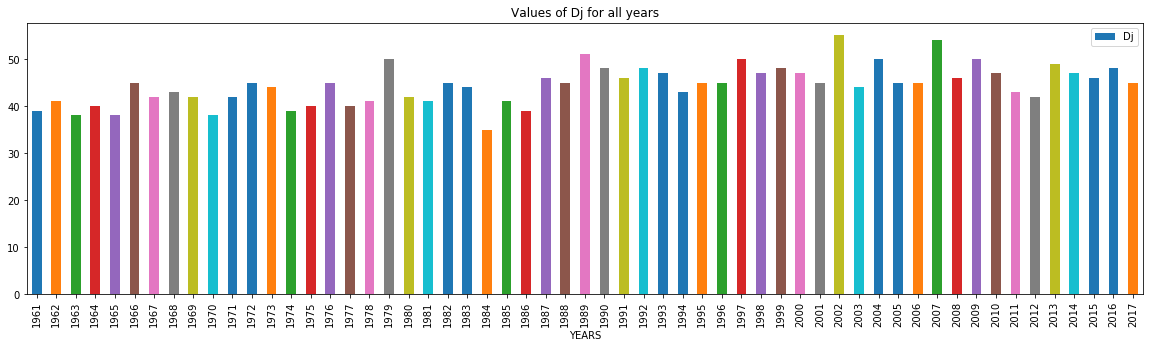

In [41]:
Dj_all.plot(y='Dj',x='YEARS',kind='bar',figsize=(20,5),title='Values of Dj for all years')

### Problem 2-2: (10pts)
Calcluate $DTS_j$ for each year $j$ in the training set for discrete values of $E_{a}$, varying from 5 to 40kcal ($E_{a} = 5, 6, 7, \cdots, 40 \,\rm{kcal}$), and plot this $DTS_j$ against $E_{a}$. Also calculate the average of $DTS_{j}$ over the training period, and indicate it on the plot as $DTS_{mean}$. Pay attention to the units of **every parameter** ($T_{i,j}$, $E_{a}$, ...) in the equation for $t_{s}$. 


In [42]:
Ea_list = list(range(5,41)) #Since Ea varies from 5 Kcal to 40 Kcal
print(Ea_list)       

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


In [43]:
DTSj_perEa = []
DTSmean_perEa =[]
DTS_Ea_allyear =[]
for Ea in Ea_list:
    DTSj = CalcDTSj(Ea,Dj_tr,ActualBD_tr,train_df,train_years)
    #DTSj_perEa.append(DTSj)
    #print('DTSj:',DTSj)
    DTS_Ea_allyear.append(DTSj)
    DTSmean = (sum(DTSj)/len(train_years))
    DTSmean_perEa.append(DTSmean)
DTSmean_df_tr = pd.DataFrame({'DTSmean':DTSmean_perEa,'Value of Ea(Kcal)':Ea_list})
print(DTSmean_df_tr)

      DTSmean  Value of Ea(Kcal)
0   32.207353                  5
1   30.487368                  6
2   28.871963                  7
3   27.354288                  8
4   25.927966                  9
5   24.587061                 10
6   23.326045                 11
7   22.139768                 12
8   21.023433                 13
9   19.972567                 14
10  18.983002                 15
11  18.050851                 16
12  17.172491                 17
13  16.344539                 18
14  15.563839                 19
15  14.827447                 20
16  14.132613                 21
17  13.476768                 22
18  12.857516                 23
19  12.272614                 24
20  11.719968                 25
21  11.197622                 26
22  10.703743                 27
23  10.236621                 28
24   9.794654                 29
25   9.376342                 30
26   8.980284                 31
27   8.605165                 32
28   8.249756                 33
29   7.912

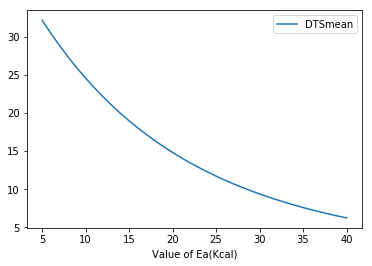

In [44]:
DTSmean_df_tr.plot(x='Value of Ea(Kcal)',y='DTSmean')

In [45]:
DTS_Ea_allyear=np.array(DTS_Ea_allyear).T

In [46]:
dts_df_plot = pd.DataFrame(DTS_Ea_allyear,index = train_years,columns = Ea_list)

In [47]:
dts_df_plot=dts_df_plot.transpose()

In [48]:
print(dts_df_plot)

         1961       1962       1963       1964       1965       1967  \
5   38.897696  38.079014  39.562942  39.134908  39.483797  36.109247   
6   36.605456  35.947260  37.229751  36.747995  36.969676  34.186211   
7   34.461601  33.944242  35.051627  34.524604  34.621374  32.389306   
8   32.455942  32.061744  33.017677  32.453076  32.427605  30.709303   
9   30.579019  30.292100  31.117802  30.522609  30.377874  29.137708   
10  28.822050  28.628152  29.342636  28.723198  28.462417  27.666698   
11  27.176876  27.063214  27.683487  27.045571  26.672153  26.289066   
12  25.635917  25.591045  26.132296  25.481134  24.998630  24.998168   
13  24.192131  24.205814  24.681582  24.021921  23.433986  23.787876   
14  22.838973  22.902074  23.324403  22.660549  21.970900  22.652537   
15  21.570359  21.674736  22.054315  21.390167  20.602562  21.586929   
16  20.380633  20.519042  20.865336  20.204424  19.322628  20.586230   
17  19.264535  19.430547  19.751911  19.097429  18.125193  19.64

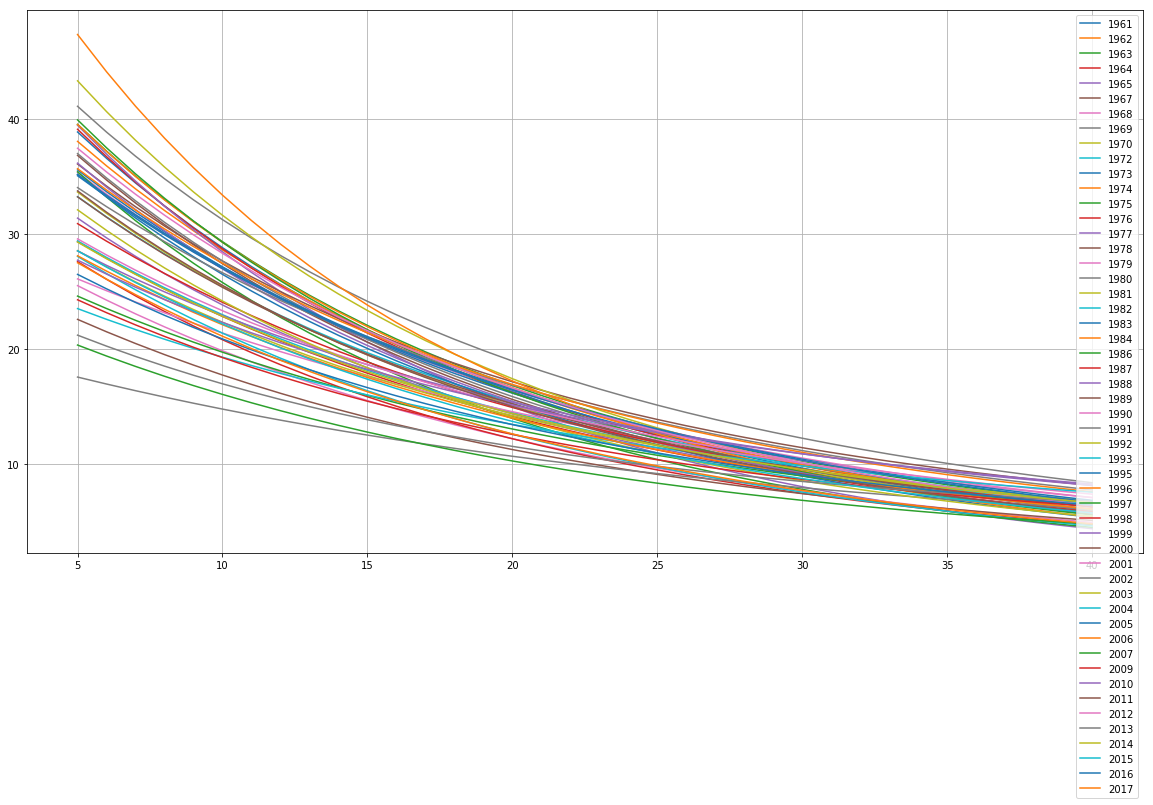

In [49]:
dts_df_plot.plot(figsize=(20,10),grid = True)

### Problem 2-3: (11pts)
Using the same $E_{a}$ values and calculated $DTS_{mean}$ from 2-2, predict the bloom date $BD_{j}$ for each of the training years. Find the mean squared error relative to the actual $BD$ and plot it against $E_{a}$. Find the optimal $E_{a}^{*}$ that minimizes that error on the training data.

In [50]:
MSE_DF= FindingMSE(train_df,Dj_tr,ActualBD_tr,DTSmean_df_tr,train_years)
print(MSE_DF)


    Ea value(Kcal)  MSE Score
0                5  58.403846
1                6  53.250000
2                7  48.903846
3                8  44.769231
4                9  39.711538
5               10  36.480769
6               11  33.211538
7               12  30.769231
8               13  27.750000
9               14  24.750000
10              15  22.480769
11              16  20.442308
12              17  19.173077
13              18  17.615385
14              19  16.346154
15              20  15.500000
16              21  14.923077
17              22  13.307692
18              23  13.500000
19              24  12.865385
20              25  12.730769
21              26  12.173077
22              27  12.307692
23              28  10.865385
24              29  11.461538
25              30  10.750000
26              31  11.019231
27              32  11.038462
28              33  11.134615
29              34  11.711538
30              35  12.000000
31              36  12.615385
32        

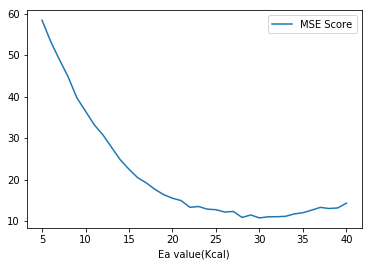

In [51]:
MSE_DF.plot(x='Ea value(Kcal)',y='MSE Score')

### Problem 2-4: (4pts)

Using the $D_j$ dates from problem 2-1, the average $DTS_{mean}$ from 2-2, and the best-fit $E_{a}^{*}$ from 2-3, predict the bloom-dates $BD_j$ for the years in the test set. Determine the error between your predicted $BD_j$ values and the actual values, and evaluate this model using the coefficient of determination ($R^2$ score).

In [60]:
DTSmean = 9.376342
Ea = 30
Tf_test = CalcTf(test_df,test_years)
Dj_test = CalcDj(Fi,L,Tf_test,test_years)
pred_test_optEa=PREDByBestEaDTSmeas(test_df,Dj_test,ActualBD_test,Ea,DTSmean,test_years)
print(pred_test_optEa)

   day:actual  day:predicted  years
0          79             79   1966
1          89             88   1971
2          93             92   1985
3          90             91   1994
4          82             83   2008


In [56]:
DTSmean = 9.376342 
Ea = 30
Tf_test = CalcTf(test_df,test_years)
Dj_test = CalcDj(Fi,L,Tf_test,test_years)
pred_test_optEa=PREDByBestEaDTSmeas(test_df,Dj_test,ActualBD_test,Ea,DTSmean,test_years)
print(pred_test_optEa)
DTSmean

   day:actual  day:predicted  years
0          79             80   1966
1          89             89   1971
2          93             93   1985
3          90             92   1994
4          82             84   2008


9.376342

In [61]:
PRED_optEa=np.array(pred_test_optEa['day:predicted'])
ActualBD_test = ActualBD(test_df,test_years)
ACT_BD_optEa = np.array(ActualBD_test['day:actual'])

In [62]:
R2_Score_optEa = CalcR2Score(ACT_BD_optEa,PRED_optEa)
print("R2 Score for best DTS is: ",R2_Score_optEa)

R2 Score for best DTS is:  0.9708454810495627


### Problem 2-5: (extra 10pts)
Discuss any improvements you could make to the model outlined above. If you have a suggestion in particular, describe it. How much do you think the accuracy would be improved?

1.According to the mentioned model and datasets, there is an assumption that the average temperature of a single day is sustained throughout the day. This is not the case in real life as the temperature can flactuate even from hour to hour. So if the fluctuations of the temperature could be added, the accuracy and could possibly be improved.



2.There are different species of cherry trees from the Prunus genus. Different species of trees might have different type if implecations to different changes of variables. We did not take that into account. If we can take those things into consideration, accuracy might be improved.


### Suggested improvements:
1. Sakura blooming depends on a lot of variables such as maximum and minimum temperature of the day, precipitation, available sun hours etc. These variables are no less important that features included in the model outlined above. So inclusion of these variables in the above model can improve the model's accuracy.
2. Besides air composition can be an important factor for Sakura bloomimg because percentage of Carbon Di Oxide in air directly affects photosynthesis and respiration of trees. The model should also take this into account.

***
## 3. Predicting Bloom-date via Neural Network (30pts total)

# Data analysis

In [63]:
c_df = df.copy()
c_train_df = train_df.copy()
c_test_df = test_df.copy()

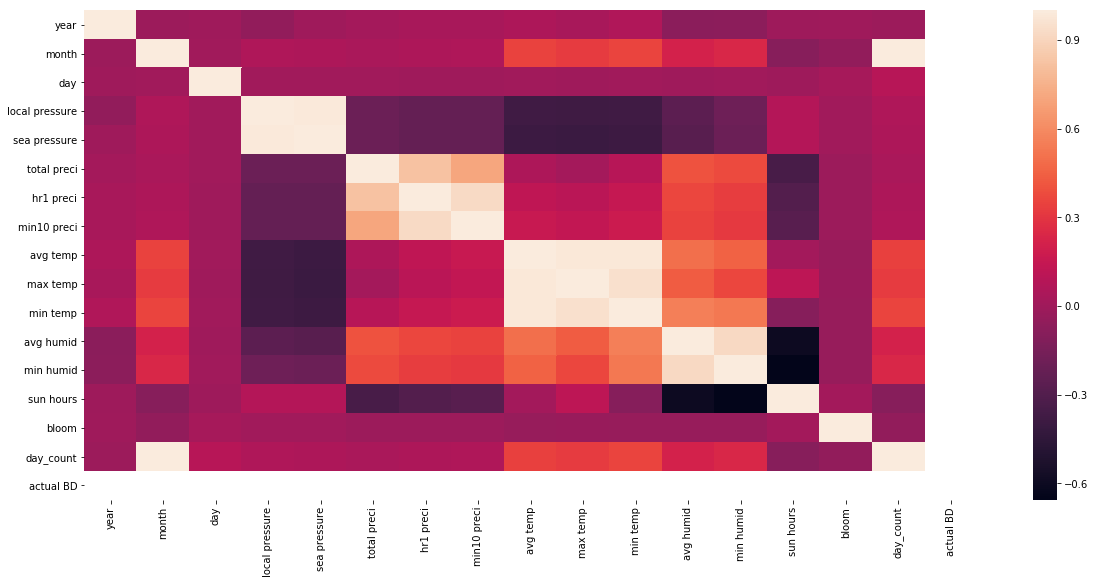

In [64]:
#OBESERVING HEAT MAP
corr_df = c_df.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corr_df)

### Correlation analysis among attributes:

Highly correlated features:
1. Temperature and precipitation
2. Temperature and humidity
3. Humidity and precipitation
4. Pressure and temperrature(negative)
5. Average humidity and sun hours

We will analyze these correlations while discussing environmental blooming factors for sakura.

In [65]:
C_ACTULABD_DF = ActualBD_df.copy()

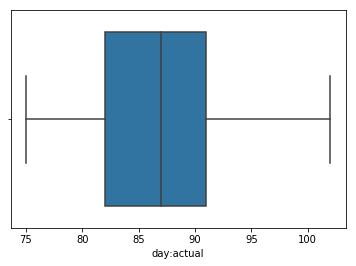

In [66]:
sns.boxplot(C_ACTULABD_DF['day:actual'])

## Blooming factors for Sakura:
To predict the blooming day of Sakura accurately, we need to know aout the factors that affect Sakura blooming and their correlations.Various environmental factors affect when plants open their flowers, including day length, air temperature, and soil moisture.[1]<br>
The most important factor in blooming of Sakura is temperature.<br>
    -Chilly days during the winter and warm or mild days during the spring generally accelerate the maturation of flower buds.<br>
    -By contrast, unseasonable winter warmth and unseasonable springtime chills can slow the process.[3]<br>
## Feature engineering decisions:
1. From above mentioned points obviously minimum temperatures, maximimum temperatures and averarge temperatures all play signifant role in sakura blooming. But our interest should be the winter and spring season just before the season of sakura. Hence, here we have considered the first three months of each year for each feature.<br>
2. Soil moisture highly depends on ammount of precipitaion. So total precipitation of first three months of each year were also considered. Sun hours was also considiered as a feature.<br>
3. Even though humidity is highly correlated to temperature, precipitaion and sun hours, this feature was not included because it degrades the performance on the NN model. This may be because we have limited number of training data and unnecessary number of features can hamper the performance of the model. 
4. Since the place was fixed so presssure remained almost same during our interest period over the years. So pressure values were not included as feature. If we need to predict the blooming dateof Sakura for different places, we need to consider air pressure also.<br>
5. Year was considered a feature to take account of the gradual change in overall environment.

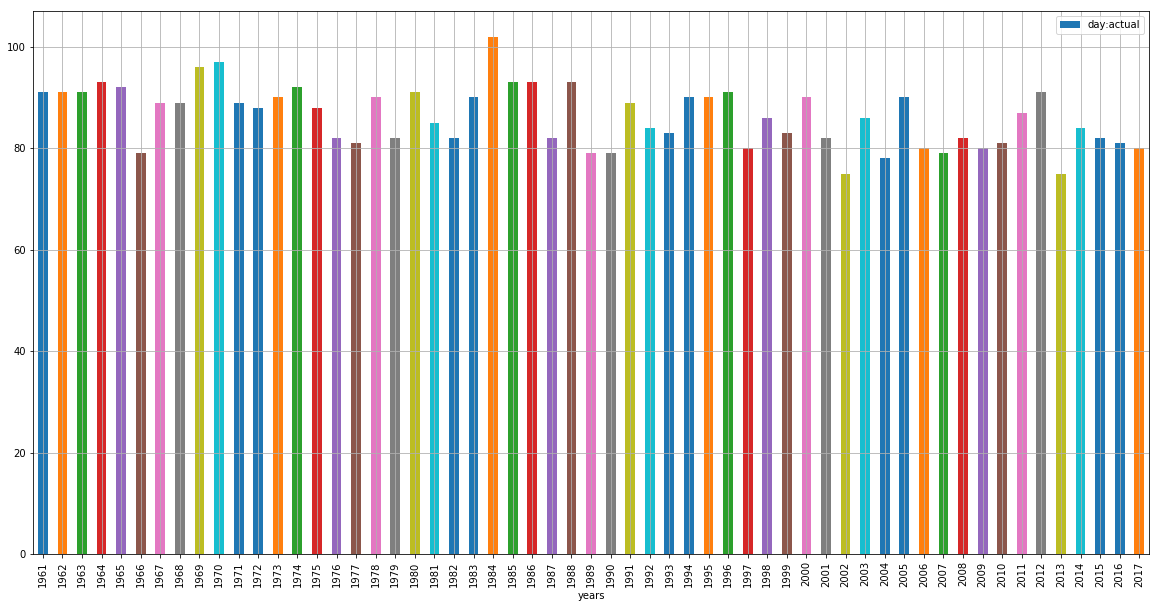

In [67]:
C_ACTULABD_DF.plot(x='years',y='day:actual',kind='bar',grid=1,figsize=(20,10),xticks=list(range(1961,2018,2)))

### Evidence behind decisions:
From the above plot, we can see blooming occured later than usual times in 1969,1970 and 1984. If we analyze our data, we can easily observe that winters were warmer than usual(~6 degree celcius) and springs were colder(~7.5) than usual.<br>
In 1966,1989,1997,2002,2013 winters were colder(~3) than usual and springs were warmer(>9 degree celcius) that usual. So as mentioned above, blooming occured pretty early. This proves that our model is expected to give satisfactory result since we have also emphasised on various temperature features of the first three months


# Feature engineering

In [68]:
new_df = CreateFeat(df,all_years,1,3,'avg temp')
new_df2 = CreateFeat(df,all_years,1,3,'min temp')
new_df3 = CreateFeat(df,all_years,1,3,'total preci')
new_df5 = CreateFeat(df,all_years,1,3,'sun hours')

In [69]:
jan_mintemp = new_df2[1].values.tolist()
feb_mintemp = new_df2[2].values.tolist()
march_mintemp = new_df2[3].values.tolist()
jan_p = new_df3[1].values.tolist()
feb_p = new_df3[2].values.tolist()
march_p = new_df3[3].values.tolist()
jan_sun = new_df5[1].values.tolist()
feb_sun = new_df5[2].values.tolist()
march_sun = new_df5[3].values.tolist()

In [70]:
act_bd_list = ActualBD_df['day:actual'].values.tolist()

In [71]:
new_df['day:actual']=act_bd_list
new_df['min_temp_jan']= jan_mintemp
new_df['min_temp_feb']= feb_mintemp
new_df['min_temp_mar']= march_mintemp
new_df['preci_jan']= jan_p
new_df['preci_feb']= feb_p
new_df['preci_mar']= march_p
new_df['sun_jan']= jan_sun
new_df['sun_feb']= feb_sun
new_df['sun_mar']= march_sun
new_df.set_index('year',inplace=True,drop=False)

In [72]:
print(new_df)

             1         2          3  year  day:actual  min_temp_jan  \
year                                                                  
1961  3.570968  4.528571   8.222581  1961          91     -0.680645   
1962  4.545161  5.939286   8.248387  1962          91     -0.500000   
1963  3.170968  4.800000   7.635484  1963          91     -2.625806   
1964  5.400000  4.186207   7.570968  1964          93      1.570968   
1965  4.400000  4.671429   6.925806  1965          92      0.570968   
1966  4.648387  7.217857   9.558065  1966          79      0.135484   
1967  4.445161  4.932143   9.490323  1967          89      0.148387   
1968  5.703226  4.337931  10.025806  1968          89      0.903226   
1969  5.719355  5.664286   7.858065  1969          96      1.377419   
1970  4.529032  5.992857   5.548387  1970          97      0.409677   
1971  5.122581  5.853571   8.303226  1971          89      1.674194   
1972  6.587097  5.113793   9.661290  1972          88      2.822581   
1973  

# Preparing labels for NN model

In [73]:
test_labels = new_df.loc[test_years,'day:actual'].values
train_labels = new_df.loc[train_years,'day:actual'].values
del new_df['day:actual']

# Scaling feature values
Among various scalers(Standard,MinMax,Robust) Robust scaler performed best. Hence Robust Scaler is used here to scale the features.
## Why scaling is needed:
Most machine learning algorithms take into account only the magnitude of the measurements, not the units of those measurements.
That’s why one feature, which is expressed in a very high magnitude (number), may affect the prediction a lot more than an equally important feature.<br>

In [74]:
col_names = new_df.columns.values.tolist()
robust_scaler = RobustScaler()
new_df[col_names] = robust_scaler.fit_transform(new_df[col_names])

In [75]:
new_df = pd.DataFrame(new_df)
new_df.head()

,1,2,3,year,min_temp_jan,min_temp_feb,min_temp_mar,preci_jan,preci_feb,preci_mar,sun_jan,sun_feb,sun_mar
year,,,,,,,,,,,,,
1961,-1.391579,-0.979978,-0.533465,-1.000000,-1.400716,-1.800000,-0.723757,-0.032967,-0.076271,0.1675,-0.063253,0.769575,0.000000
1962,-0.755789,-0.127354,-0.517717,-0.964286,-1.300537,-1.023656,-1.057090,0.000000,-0.584746,-0.8600,0.753012,0.704698,0.240997
1963,-1.652632,-0.815929,-0.891732,-0.928571,-2.479428,-1.395699,-1.156538,-0.885714,-0.452542,-0.3300,1.367470,0.814318,0.490305
1964,-0.197895,-1.186900,-0.931102,-0.892857,-0.152057,-1.113608,-1.204420,2.287912,0.233781,-0.0050,-1.840361,-0.396127,0.495845
1965,-0.850526,-0.893636,-1.324803,-0.857143,-0.706619,-1.350538,-1.482505,0.164835,-0.635593,-1.3850,-0.310241,0.668904,1.975069


# Preparing train and test data for NN model

In [76]:
new_test_df =new_df.loc[ test_years , : ]
new_train_df =new_df.loc[ train_years , : ]

In [77]:
train = new_train_df.copy()
test = new_test_df.copy()

In [78]:
train =np.array(train)
test =np.array(test)
train_labels =np.array(train_labels)
test_labels =np.array(test_labels)
train_labels =train_labels.reshape(-1,1)

### Problem 3-1: (20pts)

Build a neural network and train it on the data from the training years. Use this model to predict the bloom-dates for each year in the test set. Evaluate the error between predicted dates and actual dates using the coefficient of determination (R2 score). Only use the weather data given in `tokyo.csv` and the sakura data acquired in problem 0-1.</br>
You may use whichever framework or strategy that you like to construct the network. 

## Tuning hyperparameters and decision of best model:
### a) No of input features: 
#### 1. Avg temp of January and March:
r2 score: 0.672
#### 2. Average temp of February and March:
r2 score: 0.7303
#### 3. Average temp of January-March and min temp of January:
r2 score: 0.7594
#### 4. Average and min temp of January-March:
r2 score: 0.82507
#### 5. Average, min and max temp of January-March:
r2score: 0.77405
#### 6. Average and min temp and total precipitation of January-March:
r2 score: 0.839
#### 7. Average, min temp,total pricipitation, avg humidity and sun hours of January-March: 
r2 score: 0.665
#### 8. Average,min temp, total precipitation and sun hours of January-March:
r2 score: 0.87609
All of the above model included 'year' as feature values. 
#### 9. Best model without including 'year' as feature:
r2 score: 0.81

### b) Tuning number of layers:
ANN model with 1 hidden layer gave an r2 score of 0.87609 on test data and 0.81014 on train data.<br>
![Layers](Graphs/22_1.png)<br>


ANN model with 2 hidden layer gave an r2 score of 0.81778 on test data and 0.6709 on train data.<br>
![Layers](Graphs/24.png)<br>

ANN model with no hidden layer gave an r2 score of 0.91 on test data and 0.77 on train data.<br>
![Layers](Graphs/18.png)<br>

Since the ANN model with 1 hidden layer gave satisfactory values in both test and train data, this model was chosen.

### c)  Activation function:
With activation: 0.6428<br>
![Layers](Graphs/20.png)<br>

Without activation: 0.876<br>
![Layers](Graphs/21.png)<br>

### d) Batch size:
no of batch: 5, r2 score = 0.6356<br>
![Layers](Graphs/5.png)<br>

no of batch: 8, r2_score = 0.7594<br>
![Layers](Graphs/6.png)<br>

no of batch: 9, r2_score = 0.68<br>
![Layers](Graphs/7.png)<br>

### e) Regularization constant:<br>
value: 0.5, score: 0.5116<br>
![Layers](Graphs/3.png)<br>

value: 0.1, score = 0.6793<br>
![Layers](Graphs/2.png)<br>

value: .01, score = 0.7157<br>
![Layers](Graphs/1.png)<br>

### f) Optimizer:
Among various optimizer, Adadelta, Gradient descent were really slow and but could not converge that much even with high values of epoch and low learning rate. Adagrad was slightly better. RMSPropOptimizer performed best among these with moderate epoch and learning rate. 

### g) Epochs and Learning rate:
Various combination of epochs and learning rates for various optimizer has been tried. Among them the best values are chosen based on training and validation error(MSE) and r2 score of test ant training data. Initially 70% data were used for training and 30% for cross validation. Final training are done for all training data and r2 scores are reported for both training and test set.

In [79]:
LearningRate = .01
epoch = 190
reg_const = .01

In [80]:
#Variable declarartions
input_node = train.shape[1]
hid_1 = int(input_node/2)
#hid_2 = int(input_node/2)
output_node = 1
with tf.variable_scope("WB", reuse=tf.AUTO_REUSE):
    w1= tf.Variable(tf.get_variable('w1',[input_node, hid_1],dtype=tf.float64))
    w2= tf.Variable(tf.get_variable('w2',[hid_1, output_node],dtype=tf.float64))
    #w3= tf.Variable(tf.get_variable('w3',[hid_2, output_node],dtype=tf.float64))
b1= tf.Variable(tf.zeros([hid_1],dtype=tf.float64))
#b2= tf.Variable(tf.zeros([hid_2],dtype=tf.float64))
b2= tf.Variable(tf.zeros([output_node],dtype=tf.float64))
weights= [w1,w2]
biases = [b1,b2]


In [83]:
input_feat = tf.placeholder(tf.float64, shape=[None, train.shape[1]]) 
output_labels=tf.placeholder(tf.float64, shape=[None, 1])
hlayer_1 = tf.add(tf.matmul(input_feat, weights[0]),biases[0])
#hlayer_2 = tf.add(tf.matmul(hlayer_1, weights[1]),biases[1])
#hlayer_1 =tf.nn.relu(hlayer_1)
out = tf.add(tf.matmul(hlayer_1, weights[1]),biases[1])
mse_loss = tf.losses.mean_squared_error(labels=output_labels, predictions=out)
mse_loss=tf.cast(mse_loss,tf.float64)



reg_const=np.float64(reg_const)
_reg=0.5*tf.reduce_sum(tf.square(weights[0]))   #Applying L2 regularization formula
_reg+=0.5*tf.reduce_sum(tf.square(weights[1]))
reg=tf.cast(_reg,tf.float64)
reg_loss =tf.multiply(np.float64(0.5),tf.add(mse_loss,tf.multiply(reg_const,reg)))
optimizer = tf.train.RMSPropOptimizer(LearningRate)
func_to_opt = optimizer.minimize(reg_loss)

#Running sessions
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

#Setting BatchSize and splitting value for validation
no_of_batch=8
no_of_train_batch=int(0.99*no_of_batch)
train_batch=np.array_split(train,no_of_batch)
labels_of_train_batch=np.array_split(train_labels,no_of_batch)

#Training and validation phase
loss_tr=[]
loss_va=[]

for i in range(epoch):
    
    train_loss=0
    for j in range(0,len(train_batch)):
        single_train_batch={input_feat:train_batch[j],output_labels:labels_of_train_batch[j]}
        _= sess.run((func_to_opt),feed_dict=single_train_batch)
        trainbatch_loss = sess.run((mse_loss),feed_dict=single_train_batch)
        train_loss+=trainbatch_loss
    train_loss=train_loss/(j+1)
        
    val_loss=0
    for k in range(no_of_train_batch,no_of_batch):
        single_cv_batch={input_feat:train_batch[k],output_labels:labels_of_train_batch[k]}
        valid_loss = sess.run((mse_loss),feed_dict=single_cv_batch)
        val_loss+=valid_loss
        
    val_loss=val_loss/(no_of_batch-no_of_train_batch)
    loss_tr.append(train_loss)
    loss_va.append(val_loss)
    
    print('epoc:',i,'train_loss',train_loss,'valid_loss',val_loss)

epoc: 0 train_loss 7293.5238037109375 valid_loss 6509.58837890625
epoc: 1 train_loss 7160.042541503906 valid_loss 6363.44677734375
epoc: 2 train_loss 7018.608642578125 valid_loss 6197.16064453125
epoc: 3 train_loss 6858.920227050781 valid_loss 6008.31640625
epoc: 4 train_loss 6680.4144287109375 valid_loss 5798.244140625
epoc: 5 train_loss 6484.1453857421875 valid_loss 5569.18310546875
epoc: 6 train_loss 6271.630554199219 valid_loss 5323.56787109375
epoc: 7 train_loss 6044.532470703125 valid_loss 5063.82373046875
epoc: 8 train_loss 5804.561340332031 valid_loss 4792.32080078125
epoc: 9 train_loss 5553.44873046875 valid_loss 4511.38916015625
epoc: 10 train_loss 5292.947998046875 valid_loss 4223.33544921875
epoc: 11 train_loss 5024.838073730469 valid_loss 3930.458984375
epoc: 12 train_loss 4750.927062988281 valid_loss 3635.062744140625
epoc: 13 train_loss 4473.054504394531 valid_loss 3339.451904296875
epoc: 14 train_loss 4193.087921142578 valid_loss 3045.9296875
epoc: 15 train_loss 3912.91

epoc: 128 train_loss 4.948465526103973 valid_loss 5.696584224700928
epoc: 129 train_loss 4.941949516534805 valid_loss 5.687927722930908
epoc: 130 train_loss 4.935685694217682 valid_loss 5.679368495941162
epoc: 131 train_loss 4.929670214653015 valid_loss 5.6709136962890625
epoc: 132 train_loss 4.923889368772507 valid_loss 5.662558078765869
epoc: 133 train_loss 4.9183478355407715 valid_loss 5.654300689697266
epoc: 134 train_loss 4.913029342889786 valid_loss 5.646145343780518
epoc: 135 train_loss 4.907924145460129 valid_loss 5.6380839347839355
epoc: 136 train_loss 4.90303772687912 valid_loss 5.6301045417785645
epoc: 137 train_loss 4.898356109857559 valid_loss 5.622209072113037
epoc: 138 train_loss 4.893877029418945 valid_loss 5.614409923553467
epoc: 139 train_loss 4.889594078063965 valid_loss 5.606703281402588
epoc: 140 train_loss 4.885498255491257 valid_loss 5.599067211151123
epoc: 141 train_loss 4.881581783294678 valid_loss 5.591522693634033
epoc: 142 train_loss 4.877849251031876 valid_

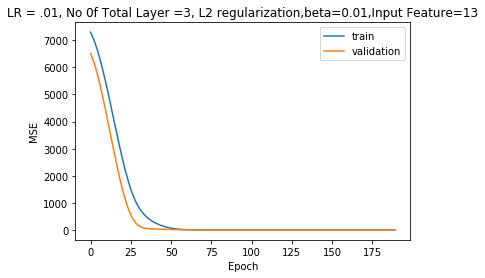

In [84]:
#Plotting
plt.title('LR = .01, No 0f Total Layer =3, L2 regularization,beta=0.01,Input Feature=13')
plt.plot(loss_tr[:], label = 'train')
plt.plot(loss_va[:],label='validation')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [85]:
#Prediction on test data
in_test={input_feat:np.array(test)}
pred_test = sess.run((out),feed_dict=in_test)
pred_test = pred_test.reshape(-1)
for i in range(len(pred_test)):
    pred_test[i]=int(pred_test[i])

In [88]:
r2_test_NN = r2_score(test_labels,pred_test)
print('r2 score by NN:',r2_test_NN)

r2 score by NN: 0.8760932944606414


In [89]:
in_train={input_feat:np.array(train)}
pred = sess.run((out),feed_dict=in_train)
pred = pred.reshape(-1)
for i in range(len(pred)):
    pred[i]=int(pred[i])

In [90]:
r2_train_NN = r2_score(train_labels,pred)
print('r2 score by NN:',r2_train_NN)

r2 score by NN: 0.8101426755191411


### Problem 3-2: (10pts)
Compare the performance (via $R^2$ score) of the 3 implementations above: the 600 Degree Rule, the DTS method, and the neural network approach. For all methods, and each test year, plot the predicted date vs. the actual date. Discuss the accuracy and differences of these 3 models.

# Comparison between 3 implementations by R2 Score(On test data):
 1. 600 Degree rule: 0.67930
 2. DTS method: 0.91253
 3. Neural network approach: 0.87609


In [91]:
comparison_df = pd.DataFrame({'day:actual':test_labels,'year':test_years,'Pred by NN':pred_test,'Pred by 600D.R':pred_test_600,'Pred by DTS':ACT_BD_optEa})
comparison_df.head()

,Pred by 600D.R,Pred by DTS,Pred by NN,day:actual,year
0,79,79,81.0,79,1966
1,86,89,87.0,89,1971
2,88,93,90.0,93,1985
3,87,90,90.0,90,1994
4,83,82,82.0,82,2008


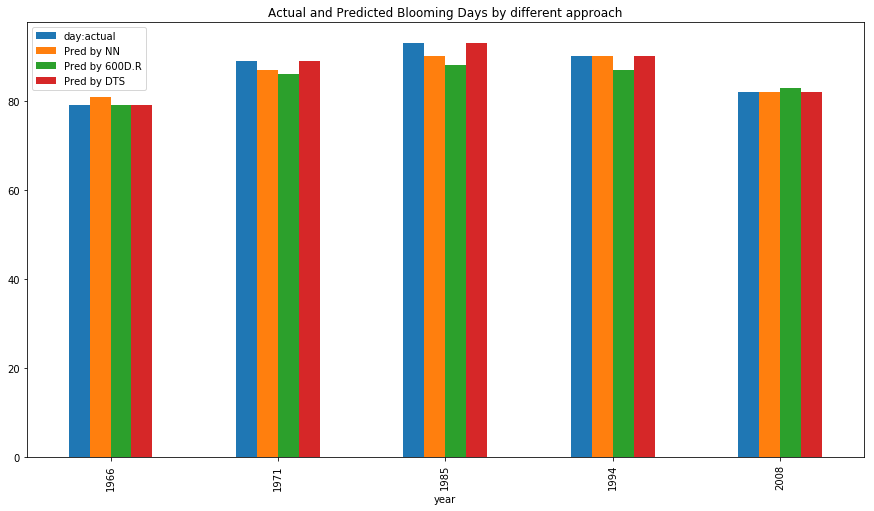

In [92]:
comparison_df.plot(x='year',y=['day:actual','Pred by NN','Pred by 600D.R','Pred by DTS'],kind='bar',figsize=(15,8),title='Actual and Predicted Blooming Days by different approach')

# Discussion:
As we have seen from the test scores, Tmean = 638 degree performed better tha 600 degree rule. DTS method performed best among all the approaches. NN approach could have performed even better if there were more data available for training. More precise domain analysis for sakura blooming factors could have resulted in better predictions. As we have seen in the NN approach, data manupulation and proper feature engineering improves the R2 scores significantly. So there is obvious scopes for better result using ANN.
One more thing to note here is the difference of test scores and train scores. In any approach, only a good test score can not ensure that the claimed model is good enough because of very low number of test data. In this case it would be wise to choose a model that gives optimum good scores in both train and test dataset rather than choosing a model which gives good score in a small model but performs porrly in a large model. 

***
## 4. Trends of the Sakura blooming phenomenon (20pts total)

### Problem 4-1: (20pts)
Based on the data from the past 60 years, investigate and discuss trends in the sakura hibernation ($D_{j}$) and blooming ($BD_{j}$) phenomena in Tokyo.

In [93]:
Dj_all['day:actual'] = ActualBD_df['day:actual']
print(Dj_all)

    Dj  YEARS  day:actual
0   39   1961          91
1   41   1962          91
2   38   1963          91
3   40   1964          93
4   38   1965          92
5   45   1966          79
6   42   1967          89
7   43   1968          89
8   42   1969          96
9   38   1970          97
10  42   1971          89
11  45   1972          88
12  44   1973          90
13  39   1974          92
14  40   1975          88
15  45   1976          82
16  40   1977          81
17  41   1978          90
18  50   1979          82
19  42   1980          91
20  41   1981          85
21  45   1982          82
22  44   1983          90
23  35   1984         102
24  41   1985          93
25  39   1986          93
26  46   1987          82
27  45   1988          93
28  51   1989          79
29  48   1990          79
30  46   1991          89
31  48   1992          84
32  47   1993          83
33  43   1994          90
34  45   1995          90
35  45   1996          91
36  50   1997          80
37  47   199

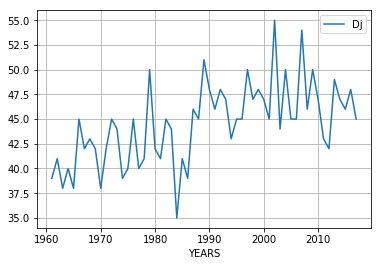

In [94]:
Dj_all.plot(x='YEARS',y='Dj',grid=True)

Dj_all.plot(x='YEARS',y='day:actual',grid=True)

# Comments on trend of blooming phenomena in Tokyo

As we can see from the graph plotted, blooming is occuring earlier than it used to 60 years ago. As we have mentioned earlier, cold winter temperature and warm spring temperature accelerates blooming date. We know one of the effects of global warming is colder winter and warmer summer. This can be the reason behind earlier blooming of sakura.[1]

## Note
This challenge was given as an assignement in the AI training program of Hiperdyne Corporation. Please use the content only for learning purposes.Plagiarizing is strictly prohibited. -Sumaiya Saima,AI engineer,Hiperdyne.

# References:
1. https://slate.com/news-and-politics/2007/03/how-do-horticulturists-know-when-the-cherry-blossoms-will-bloom.html
2. https://www.jma.go.jp/jma/en/menu.html
3. American Horticultural Society research